# Building makemore

A simple character-level language model

In [2]:
words = open("names.txt", "r").read().splitlines()

In [3]:
words[:5], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [3]:
min(len(word) for word in words), max(len(word) for word in words)

(2, 15)

## 1. Bi-gram model

In [4]:
bigrams_freq = {}
for w in words:
    # Add a start and end token
    chars = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chars, chars[1:]): # Nice trick to get pairs because Python stops the iterator once one of the iterables runs out of elements
        bigram = (ch1, ch2)
        bigrams_freq[bigram] = bigrams_freq.get(bigram, 0) + 1

In [5]:
# Cool trick to sort backwards when sorting by a numeric value, just add a negative
sorted(bigrams_freq.items(), key=lambda kv: -kv[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

Cool, but it's gonna be more efficient/useful to store this bigram frequency in a tensor instead of a dict. Pytorch time!

In [6]:
import torch

Create a string to int mapping first

In [6]:
all_chars = sorted(list(set("".join(words)))) 
stoi = {s:i+1 for i, s in enumerate(all_chars)}
# stoi["<S>"] = 26
# stoi["<E>"] = 27
stoi["."] = 0
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [7]:
itos = {v: k for k, v in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [9]:
N = torch.zeros((27, 27), dtype=torch.int32)

for w in words:
    # Add a start and end token
    # chars = ["<S>"] + list(w) + ["<E>"]
    chars = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        N[idx1, idx2] += 1

Visualize the tensor

(-0.5, 26.5, 26.5, -0.5)

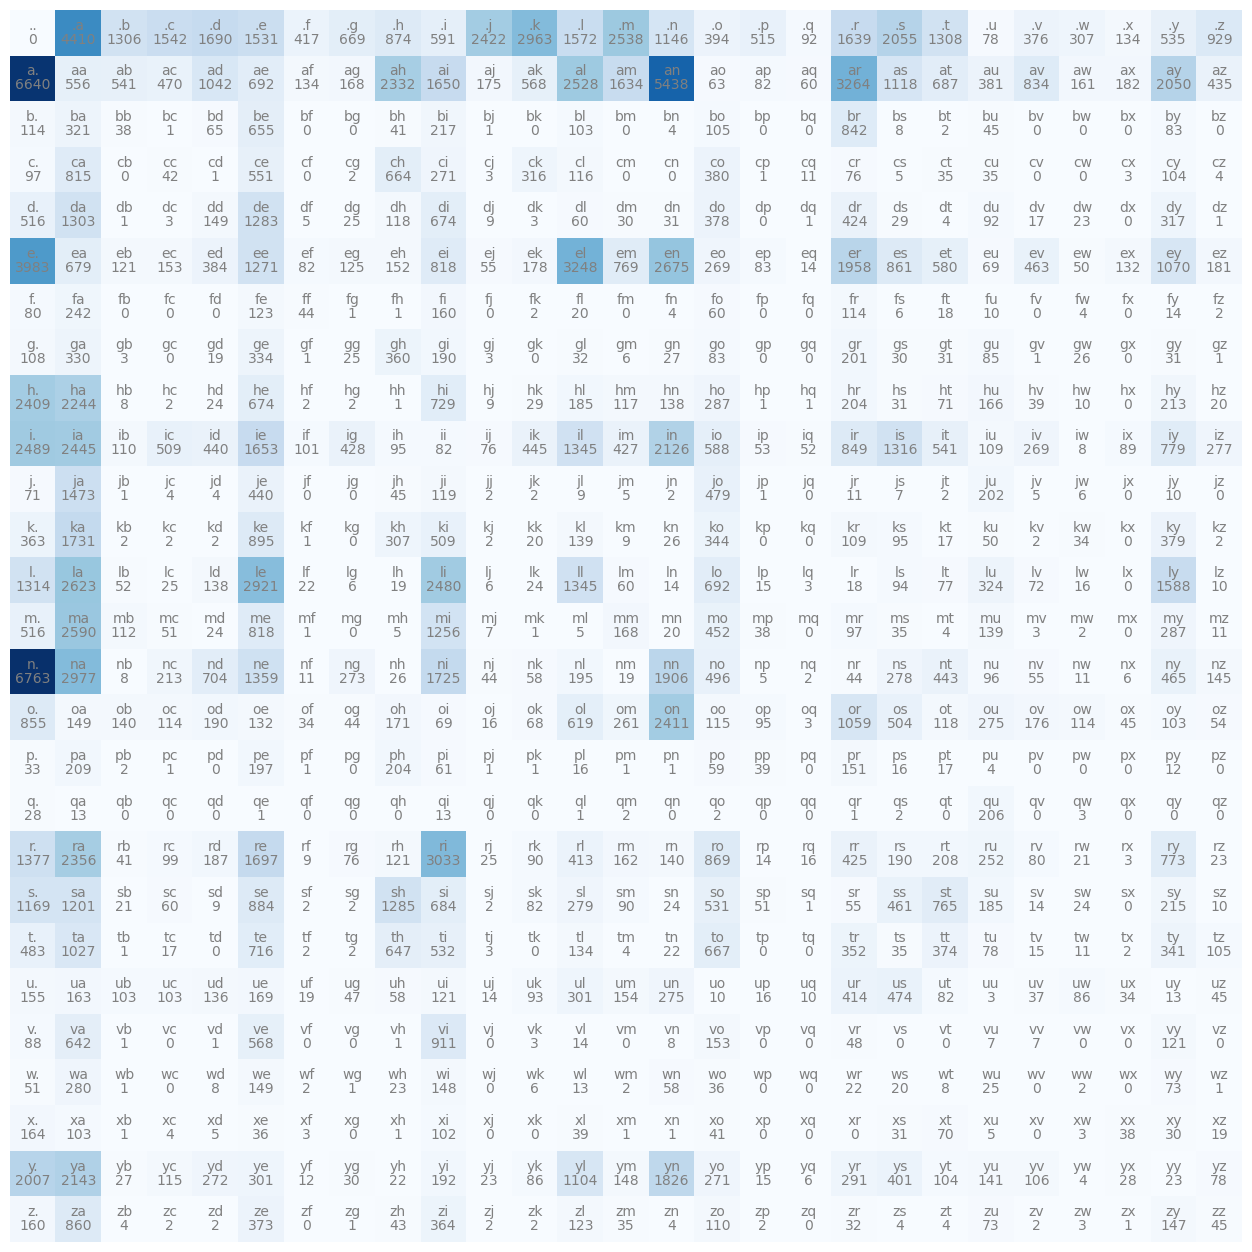

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the frequency matrix
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")

# But add the information of bigram frequencies
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")

# Axis of plots is not that useful
plt.axis("off")

In [11]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [12]:
# Turn the frequencies into probabilities
probs = N[0].float()
probs /= probs.sum()
probs,sum(probs)

(tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
         0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
         0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290]),
 tensor(1.))

In [13]:
# Play around with torch generators as a way to get deterministic results
generator = torch.Generator().manual_seed(2147483647)
probs = torch.rand(3, generator=generator)
probs

tensor([0.7081, 0.3542, 0.1054])

In [14]:
# Play around with sampling from the distribution we just created
torch.multinomial(probs, num_samples=20, replacement=True, generator=generator)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [15]:
# Sample from the distribution we just for the actual characters
generator = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(probs, num_samples=1, generator=generator, replacement=True)
ix.item(), itos[ix.item()]

(1, 'a')

In [16]:
# Efficiency improvement: Calculate the probabilities beforehand and store them in a matrix
# POST-EVALUATION NOTE: Add model smoothing by adding fake counts, 
# otherwise you're gonna get a 0 probability for pairs of characters that have never occurred together, which means you'll get an infinity in negative log likelihood hehe
P = (N + 1).float() 

# Remember: We're able to do this division because of the rules of broadcasting
# -> Align all dims to the right
# -> Starting from the right, the dimensions are either equal, one of them is a 1, or one of them is None
# NOTE: If we didn't have keepdim=True, we'd end up normalizing the columns instead of the rows!!
P /= P.sum(dim=1, keepdim=True)
P[0], P[0].sum()

(tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
         1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
         4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
         5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
         4.2109e-03, 1.6719e-02, 2.9008e-02]),
 tensor(1.))

In [17]:
# Efficiency improvement pt 2: 
# We were already doing it! 
# By using the /= operator we were doing an implace operation and saving up memory in the background (otherwise we would have created a new tensor in the background

In [18]:
generator = torch.Generator().manual_seed(2147483647)

# Sample/generate 20 names
sample_size = 25
for i in range(sample_size):
    out = []
    ix = 0
    
    while True:
        probs = P[ix]
        ix = torch.multinomial(probs, num_samples=1, generator=generator, replacement=True).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoynayrkiedengin.
torrederahnn.
ellovyllobrqura.
ay.
h.
kn.


Not the best language model hehe. Clearly because it doesn't have enough context.

Ok but how BAD is it? Let's evaluate it somehow. 

A random model would asign everything equal probability (1/27). So anything above a 4% probability implies some learning!


Ok so how do we measure quality?
- The likelihood is defined as the product of all probabilities. 
- The higher the better, indicates better quality of a model. This is because the model would be choosing for character 1, the most likely (correct) character 2 and it would do this for all character 1s. If this is low, then it is just choosing the wrong character 2s for most character 1s.
- But a more "workeable" number is the log likelihood instead, because the likelihood is usually a TINY number.
    - Monotonic transformation where, if you pass in 1 gets you log(1) = 0
    - The lower the probability, the more negative the log will be (up to 0 and negative infinity)
- One final thing. 
    - For loss functions, we like the association that "low" is "good", because we're trying to minimize the loss. 
    - And in the normal log likelihood, we actually have that "high" is good (since the closer the probability is to 1, the closer the log likelihood is to 0 and that's the highest point). THEREFORE, we use the negative log likelihood :) Because the lowest it can get is 0 (and that's the best we can do), and then it can go up to positive infinity for an arbitrarily bad score.
    
    
Therefore:
- Our GOAL is to MAXIMIZE likelihood of the data w.r.t the model parameters (statistical modeling framework)
- which is equivalent to maximizing the log likelihood (since the log function is monotonic, it's just scaling)
- which is equivalent to minimizing the negative log likelihood
- which is equivalent to minimizing the average negative log likelihood (which people do for convenience) 

In [19]:
log_likelihood = 0.0
n = 0

for w in words:
    # Add a start and end token
    # chars = ["<S>"] + list(w) + ["<E>"]
    chars = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        # print(f"{ch1}{ch2}: {prob: .4f} {logprob: .4f}")
        n += 1
        # Remember: log(a*b*c) = log(a) + log(b) + log(c)
        log_likelihood += logprob

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
normalized_nll = nll / n
print(f"{normalized_nll=}")

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
normalized_nll=tensor(2.4544)


In [20]:
# Check the probabilities for an uncommomn name
log_likelihood = 0.0
n = 0

for w in ["andrejq"]:
    # Add a start and end token
    # chars = ["<S>"] + list(w) + ["<E>"]
    chars = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        # print(f"{ch1}{ch2}: {prob: .4f} {logprob: .4f}")
        n += 1
        # Remember: log(a*b*c) = log(a) + log(b) + log(c)
        log_likelihood += logprob

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
normalized_nll = nll / n
print(f"{normalized_nll=}")

log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
normalized_nll=tensor(3.4834)


## 2. Single-layer Neural Network

Create a training set of bigrams first!

In [34]:
import torch.nn.functional as F

In [27]:
xs, ys = [], []

for w in words[:1]:
    chars = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):
        int1 = stoi[ch1]
        int2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(int1)
        ys.append(int2)

# Careful, if you use torch.Tensor the dtype will be automatically converted to a float32 (so it will be a FloatTensor), whereas torch.tensor just infers the type.
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [28]:
xs

tensor([ 0,  5, 13, 13,  1])

In [29]:
ys

tensor([ 5, 13, 13,  1,  0])

In [62]:
xenc = F.one_hot(xs, num_classes=27).float()
xenc, xenc.shape

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([5, 27]))

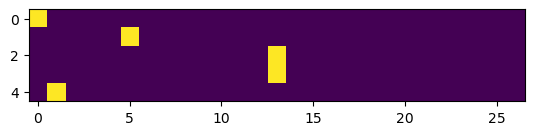

In [45]:
plt.imshow(xenc)

Construct our neat NN

In [76]:
# Shape operations: 
# > (5, 27) @ (27, 1) = (5, 1)
# > (5, 27) @ (27, 27) = (5, 27)

# Initialize a NN layer
generator = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=generator) # (Number of inputs, number of neurons)

# Recall that @ is matrix product (matrix version of dot product = multiply then add)
prod = xenc @ W

# Look at the output of the 13th neuron when given the third neuron
prod[3, 13]

tensor(0.0379)

How to interpret the output of our single-layered, 27-neuron neural network? 
**The scores represent *log counts***. LOGITS!!!!!!!!

So we need to **exponentiate the numbers**, since the `exp()` function turns negative numbers to be between 0 and 1, and positive numbers to be greater than 1 (and even more positive? lol)

In [77]:
# Log-counts. Maybe this is just another way of interpreting what we did with the one hot encoding x weights. The equivalent of log(counts)?
logits = xenc @ W 

# These 2 steps are called the softmax()!
counts = logits.exp() # Equivalent to our old N matrix, counts
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([5, 27])

Visualize the forward pass for a couple examples

In [78]:
# 5 examples WITHIN "emma", so 5 bigrams
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item()
    y = ys[i].item()
    
    print("="*32)
    print(f"Bigram example: {i+1} = {itos[x]}{itos[y]} (indexes {x}, {y})")
    print(f"Input to the neural net: {x}")
    print(f"Output probabilities from the neural net: {probs[i]}")
    print(f"Label (actual next character): {y}")
    p = probs[i, y]
    print(f"Probability assigned by the net to the correct character: {p.item()}")
    logp = torch.log(p)
    print(f"Log likelihood: {logp.item()}")
    nll = -logp
    print(f"Negative log likelihood: {nll.item()}")
    nlls[i] = nll
    
print("="*32)
print(f"Average negative log likelihood: {nlls.mean().item()}")

Bigram example: 1 = .e (indexes 0, 5)
Input to the neural net: 0
Output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
Label (actual next character): 5
Probability assigned by the net to the correct character: 0.012286253273487091
Log likelihood: -4.3992743492126465
Negative log likelihood: 4.3992743492126465
Bigram example: 2 = em (indexes 5, 13)
Input to the neural net: 5
Output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
Label (actual next character): 13
Probability assigned by the net to the correct character: 0.01805070228874683

Ok now it's actually time to optimize it

In [81]:
xs

tensor([ 0,  5, 13, 13,  1])

In [82]:
ys

tensor([ 5, 13, 13,  1,  0])

In [100]:
# Initialize weights
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) 
W[0]

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046, -0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,
         1.5618, -1.6261,  0.6772, -0.8404,  0.9849, -0.1484, -1.4795,  0.4483,
        -0.0707,  2.4968,  2.4448], grad_fn=<SelectBackward0>)

In [127]:
# 1. Forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W 
counts = logits.exp() 
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean() # Get the probabilities we want! The probabilities that the network assigns to the next character
loss

tensor(3.6494, grad_fn=<NegBackward0>)

In [128]:
# 2. Backward pass
W.grad = None # Set gradients to zero
loss.backward()

In [129]:
# 3. Update the tensor
lr = 0.1
W.data += -lr * W.grad

In [130]:
W[0]

tensor([ 1.5588, -0.2387, -0.0291, -1.1014,  0.2835,  0.1085, -1.5474,  0.6016,
         0.0772,  0.9002, -0.4724,  0.7829, -0.3297, -0.4341,  1.3659,  2.9003,
         1.5533, -1.6264,  0.6737, -0.8412,  0.9801, -0.1499, -1.4799,  0.4455,
        -0.0724,  2.4753,  2.4244], grad_fn=<SelectBackward0>)

Join it all!

In [145]:
# Initialize the dataset
xs, ys = [], []

for w in words:
    chars = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):
        int1 = stoi[ch1]
        int2 = stoi[ch2]
        # print(ch1, ch2)
        xs.append(int1)
        ys.append(int2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num_examples = xs.nelement()
print(f"Number of examples: {num_examples}")

# Initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) 

Number of examples: 228146


In [149]:
# Gradient descent
lr = 50
n_epochs = 100

for k in range(n_epochs):
    # 1. Forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # Input
    # Another intuitive interpretation of this line - this multiplication is just looking up a row in W!
    # Our one-hot matrix is a lookup table
    logits = xenc @ W # predict log-counts. 
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num_examples), ys].log().mean() + 0.01*(W**2).mean() # This second term is the regularization strength, which nudges the weights to be closer to zero
    print(f"{loss.item()=}")
    
    # 2. Backward pass
    W.grad = None # Set gradients to zero
    loss.backward()
    
    # 3. Update the tensor
    W.data += -lr * W.grad

loss.item()=2.486083745956421
loss.item()=2.4859821796417236
loss.item()=2.4858832359313965
loss.item()=2.4857864379882812
loss.item()=2.485692024230957
loss.item()=2.4855992794036865
loss.item()=2.4855093955993652
loss.item()=2.4854211807250977
loss.item()=2.485334634780884
loss.item()=2.4852499961853027
loss.item()=2.485167980194092
loss.item()=2.485086679458618
loss.item()=2.4850080013275146
loss.item()=2.4849307537078857
loss.item()=2.4848551750183105
loss.item()=2.484781265258789
loss.item()=2.4847090244293213
loss.item()=2.4846384525299072
loss.item()=2.4845688343048096
loss.item()=2.4845008850097656
loss.item()=2.4844348430633545
loss.item()=2.4843695163726807
loss.item()=2.4843058586120605
loss.item()=2.484243154525757
loss.item()=2.484182119369507
loss.item()=2.4841222763061523
loss.item()=2.4840636253356934
loss.item()=2.4840056896209717
loss.item()=2.483949661254883
loss.item()=2.4838945865631104
loss.item()=2.4838404655456543
loss.item()=2.4837872982025146
loss.item()=2.483

**What is a good loss?** Good question. In this particular case, something around 2.47 because that's the loss we got when running a bigram approach manually! 


**Note:** When W is made of all equal numbers (or zero), the probabilities resemble a uniform distribution (uniform probabilities). Then, incentivizing the values to be near-zero but not zero is a way to "smooth" our probabilities. The optimization is trying to make the probabilities work out AND make the weights get closer to zero. The strength of the regularization is controlling the amount of counts we added to N at the beginning. Adding a lot more counts increases the regularization term, which increases the strength of the regularization and it doesn't allow the probabilities to not be uniform.


FINALLY: Generate characters using the NN model

In [164]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    output = []
    ix = 0
    while True:
        
        # ------------
        # BEFORE
        # p = P[ix]
        # ------------        
        # NOW
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float() # Input
        logits = xenc @ W # predict log-counts. 
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ------------
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        output.append(itos[ix])
        if ix == 0:
            break
            
    print("".join(output))

mor.
axx.
minaymoryles.
kondmaisah.
anchthizarie.


## 3. Multi-layer Perceptron (MLP)

Implementing "A Neural Probabilistic Language Model" by Bengio et. al.

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [194]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [195]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [196]:
len(words)

32033

In [197]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [198]:
# Re-build the dataset
block_size = 3 # Context: How many characters do we take to predict the next one?
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "---->", itos[ix])
        context = context[1:] + [ix] # Crop and append the new character (like a sliding window)

        
X = torch.tensor(X)
Y = torch.tensor(Y)
        

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [199]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [200]:
# Each of the 27 characters has a 2-dimensional embedding
C = torch.randn((27, 2))

In [201]:
C[5]

tensor([-1.0731,  1.0749])

In [202]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.0731,  1.0749])

In [207]:
# We can index and repeat rows!!
C[[4, 5, 6, 6, 7]]

tensor([[-0.1010, -0.5674],
        [-1.0731,  1.0749],
        [-2.3242,  0.2411],
        [-2.3242,  0.2411],
        [-0.8153, -0.3353]])

In [203]:
# We can embed using tensors too. :O 
C[X].shape

torch.Size([32, 3, 2])

Remember, `X` is the context (feature) tensor, where each row `i` represents `BLOCK_SIZE` characters that come before the character label `Y[i]`

In [220]:
X[13], [itos[c.item()] for c in X[13]]

(tensor([0, 0, 1]), ['.', '.', 'a'])

Remember, `C` represents the embedding tensor, where for each character `i`, `C[i] = ` 2-dimensional embedding of character `i`. Right now these are random numbers.


If `X[i] = [0, 0, 1]`, then this means that the context at position `i` is `"..a"`

Therefore, `C[X]` gives us the 2-dimensional embeddings for all contexts. So `C[X][13]` would give us the 2-dimensional row vector embeddings of `"..a"`, in this case the first 2 rows would be the same because they belong to the same character.

In [226]:
C[X][13], C[X][13].shape

(tensor([[-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-0.0520, -0.3928]]),
 torch.Size([3, 2]))

And `C[X][13, 2]` would give us the 2-dimensional embedding for the character `"a"` (represented by integer `1` below), since that's the 3rd character (1-indexed) of the context,

In [229]:
# Character "a"
X[13, 2]

tensor(1)

In [230]:
# Embedding for character "a"
C[X][13, 2]

tensor([-0.0520, -0.3928])

In [231]:
# Verify that the character embedding of "a" (or 1) is indeed what we saw
C[1]

tensor([-0.0520, -0.3928])

Ok! Time to build the hidden layer

In [232]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [233]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

But remember, we can't just multiply `emb @ W1 + b1` because we have a shape mismatch (`32, 3, 2` and `6, 100`). So we have to reduce `(32, 3, 2)` to `(32, 6)` somehow.

In [236]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

Alternative 1: Use `torch.cat()`

In [241]:
torch.cat?

Docstring:
cat(tensors, dim=0, *, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be empty.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat((x, x, x), 0)
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497],
            [ 0.6580, -1.0969,

In [235]:
# This gets the embeddings of all the first characters
emb[:, 0, :].shape

torch.Size([32, 2])

In [244]:
# Concatenate along the 1st dimension! 
torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1).shape

torch.Size([32, 6])

Alternative 2: Use `torch.unbind()` so that we don't need to manually extract the ith elements like `emb[:, 0, :]` or `emb[:, 1, :]`. This is so that if we have an arbitrary block size, we don't have to extract the ith elements manually. 

In [ ]:
torch.unbind?

In [252]:
torch.unbind(emb, 1)

(tensor([[-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-1.0731,  1.0749],
         [-0.3950, -0.6123],
         [-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [ 0.7109, -0.1051],
         [-0.6403, -0.5742],
         [-0.5555, -0.1545],
         [-0.7662,  0.3008],
         [-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-0.0520, -0.3928],
         [-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-0.5555, -0.1545],
         [ 0.5205, -2.0674],
         [-0.0520, -0.3928],
         [-0.7477, -0.4928],
         [-1.0731,  1.0749],
         [-0.6403, -0.5742],
         [-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [ 0.5205, -2.0674],
         [ 0.7109, -0.1051],
         [ 1.1215, -0.6454],
         [ 1.3987,  0.5197]]),
 tensor([[-0.4040, -1.4257],
         [-0.4040, -1.4257],
         [-1

In [253]:
len(torch.unbind(emb, 1))

3

Now we can just concat along the first axis

In [254]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

There's a better way though! Concatenation creates a new tensor for the operation to happen and it is inefficient because of the extra memory.

Alternative 3: Use `tensor.view`. 

In [256]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [257]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [258]:
a.view(3, 2, 3)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])

As long as the total number of elements (multiplied) in the view is equivalent to the original tensor, we can represent that tensor in an arbitrary number of ways! 

In [259]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 18]

AHA! This is because the tensor is always stored in as a 1-dimensional vector in memory. This is why `.view()` is a very efficient operation, since the memory remains the same (and what gets manipulated are storage offsets, strides, and shapes).

For more info: http://blog.ezyang.com/2019/05/pytorch-internals/

THEREFORE! We can just view a `(32, 3, 2)` tensor as a `(32, 6)` tensor.

In [260]:
emb.view(32, 6)

tensor([[-0.4040, -1.4257, -0.4040, -1.4257, -0.4040, -1.4257],
        [-0.4040, -1.4257, -0.4040, -1.4257, -1.0731,  1.0749],
        [-0.4040, -1.4257, -1.0731,  1.0749, -0.3950, -0.6123],
        [-1.0731,  1.0749, -0.3950, -0.6123, -0.3950, -0.6123],
        [-0.3950, -0.6123, -0.3950, -0.6123, -0.0520, -0.3928],
        [-0.4040, -1.4257, -0.4040, -1.4257, -0.4040, -1.4257],
        [-0.4040, -1.4257, -0.4040, -1.4257,  0.7109, -0.1051],
        [-0.4040, -1.4257,  0.7109, -0.1051, -0.6403, -0.5742],
        [ 0.7109, -0.1051, -0.6403, -0.5742, -0.5555, -0.1545],
        [-0.6403, -0.5742, -0.5555, -0.1545, -0.7662,  0.3008],
        [-0.5555, -0.1545, -0.7662,  0.3008, -0.5555, -0.1545],
        [-0.7662,  0.3008, -0.5555, -0.1545, -0.0520, -0.3928],
        [-0.4040, -1.4257, -0.4040, -1.4257, -0.4040, -1.4257],
        [-0.4040, -1.4257, -0.4040, -1.4257, -0.0520, -0.3928],
        [-0.4040, -1.4257, -0.0520, -0.3928, -0.7662,  0.3008],
        [-0.0520, -0.3928, -0.7662,  0.3

Back to the hidden layer calculation:

In [262]:
h = emb.view(-1, W1.shape[0]) @ W1 + b1
h.shape

torch.Size([32, 100])

Now, let's create the final layer

In [263]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [264]:
logits = h @ W2 + b2

In [265]:
logits.shape

torch.Size([32, 27])

Repeat the steps as the single-layer NN version!

In [266]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [267]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [268]:
# Give the current probabilities as assigned by the NN to the correct character in the sequence
prob[torch.arange(32), Y]

tensor([8.4553e-04, 6.1517e-43, 7.0689e-07, 1.0924e-02, 4.5736e-16, 1.4053e-25,
        5.3973e-23, 1.3699e-17, 2.0281e-07, 7.3029e-06, 4.6066e-06, 2.7322e-02,
        6.4131e-21, 1.1955e-23, 2.2187e-12, 3.8505e-05, 1.0392e-15, 1.3825e-13,
        1.2247e-30, 1.6584e-09, 5.2376e-05, 4.1095e-20, 5.6296e-14, 9.2287e-04,
        1.1777e-12, 4.5532e-10, 2.6236e-34, 1.0923e-26, 1.8959e-37, 9.9448e-01,
        7.8345e-13, 5.9168e-19])

In [269]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(33.4588)

Bring it all together!

In [270]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [274]:
g = torch.Generator().manual_seed(2147483647)

# Embedding matrix/layer
C = torch.randn((27, 2), generator=g)

# Hidden layer
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

# Output layer
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [275]:
# Total number of parameters!
sum([p.nelement() for p in parameters])

3481

In [283]:
# Forward pass including loss calculation
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
logits.shape

torch.Size([32, 27])

BUT we're bringing in `F.cross_entropy()!`

- Which is great because it is more efficient because it uses less memory (we don't create temporary tensors)
- AND Pytorch has a more efficient backward pass because it is simpler

In [285]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

- AND `F.cross_entropy()` is more "numerically well-behaved"


What does this mean?

For very positive and very negative logits, `exp()` runs out of range in the floating point numbers that can represent these numbers. So we can't pass many large logits through these expressions.

In [292]:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

In [293]:
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

Notice that by offsetting the original logits by some number (up to the max of the logits) we can still get the same probabilities results... 

In [294]:
logits = torch.tensor([-5, -3, 0, 5]) + 3
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [296]:
logits = torch.tensor([-5, -3, 0, 5]) - 5
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

So PyTorch solves this out-of-range error by subtracting `max(logits)` from the logits, which is implemented in `F.cross_entropy()`.

Therefore, 3 reasons to use `F.cross_entropy()` over your own operations:
- Forward pass is more efficient (less memory, "fused kernels"/combined operations)
- Backward pass is more efficient (simpler mathematical operations)
- More numerical stability

Time for the actual **training loop**

In [403]:
# Re-build the dataset with ALL the data
block_size = 3 # Context: How many characters do we take to predict the next one?
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "---->", itos[ix])
        context = context[1:] + [ix] # Crop and append the new character (like a sliding window)

        
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [458]:
g = torch.Generator().manual_seed(2147483647)

# Embedding matrix/layer
C = torch.randn((27, 2), generator=g)

# Hidden layer
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

# Output layer
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [447]:
sum([p.nelement() for p in parameters])

3481

In [405]:
for p in parameters:
    p.requires_grad = True

In [406]:
# for _ in range(10):
#     # forward pass
#     emb = C[X] # (32, 3, 2)
#     h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
#     logits = h @ W2 + b2 # (32, 27)
#     loss = F.cross_entropy(logits, Y)
#     print(loss.item())
#     # backward pass
#     for p in parameters:
#         p.grad = None

#     loss.backward()

#     for p in parameters:
#         p.data += -0.1 * p.grad

But each iteration is taking a while, so let's do it in mini-batches!!!!!!!

In [407]:
# Sample :)
torch.randint(0, X.shape[0], (32,))

tensor([115260,  59989, 166041,  28332,  25410,  96686, 141529, 180688, 209920,
         53560,  11662, 160644, 159230, 159525, 129711, 145611, 113035,  14940,
        183505,  21328,  80791, 121523,  42186, 185563,  18208,   7461, 157784,
         66259, 192575, 135360,  44003,  55708])

Also keep track of what's the best learning rate (to keep track of how fast the model can learn)

In [408]:
lre = torch.linspace(-3, 0, 1000)

# From 0.001 to 1.000!
lrs = 10**lre

lrs[:5], lrs[-5:]

(tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010]),
 tensor([0.9727, 0.9795, 0.9863, 0.9931, 1.0000]))

In [443]:
lri = []
lossi = []

for i in range(1000):
    
    # mini-batch construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    
# print(loss.item())

In [444]:
# plt.plot(lri, lossi)

Wow. That was an instanteneous speedup! But that means that the gradient quality is lower. Still, very useful. It is better to have an approximate gradient in more steps than the actual gradient in less steps.

In [446]:
# Calculate general loss
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss.item()

2.436811923980713

But! This only tells us the loss on the training data, and we're at risk of overfitting if we don't evaluate this model in a validation split.

So let's split it in 80/10/10 (train/val/test)

- train = evaluate parameters
- val = evaluate hyperparameters
- test = evaluate performance of the model at the end

In [455]:
# Re-build the dataset with train/val/test splits

def build_dataset(words):
    block_size = 3 # Context: How many characters do we take to predict the next one?
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "---->", itos[ix])
            context = context[1:] + [ix] # Crop and append the new character (like a sliding window)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [484]:
# Let's try increasing the size of the neural net AND the embedding size
g = torch.Generator().manual_seed(2147483647)

# Embedding matrix/layer
C = torch.randn((27, 10), generator=g)

# Hidden layer
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

# Output layer
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

11897


In [487]:
# Tracking
lri = []
lossi = []
stepi = []

In [519]:
# Train ONLY on train set
for i in range(200000):
    
    # mini-batch construction
    ix = torch.randint(0, X_train.shape[0], (32,))
    
    # forward pass
    emb = C[X_train[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y_train[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
# print(loss.item())

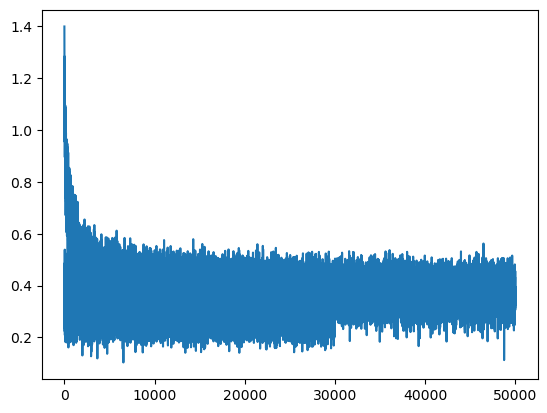

In [520]:
plt.plot(stepi, lossi)

In [521]:
print(loss.item())

2.218221664428711


In [522]:
# Calculate train loss
emb = C[X_train] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_train)
loss.item()

2.11039400100708

In [523]:
# Calculate dev loss
emb = C[X_dev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_dev)
loss.item()

2.171631097793579

A potential bottleneck in the quality of our network is the embedding size: we're trying to cram too much information in a 2-dimensional representation. Let's visualize the embeddings to check their quality before increasing their dimensions!

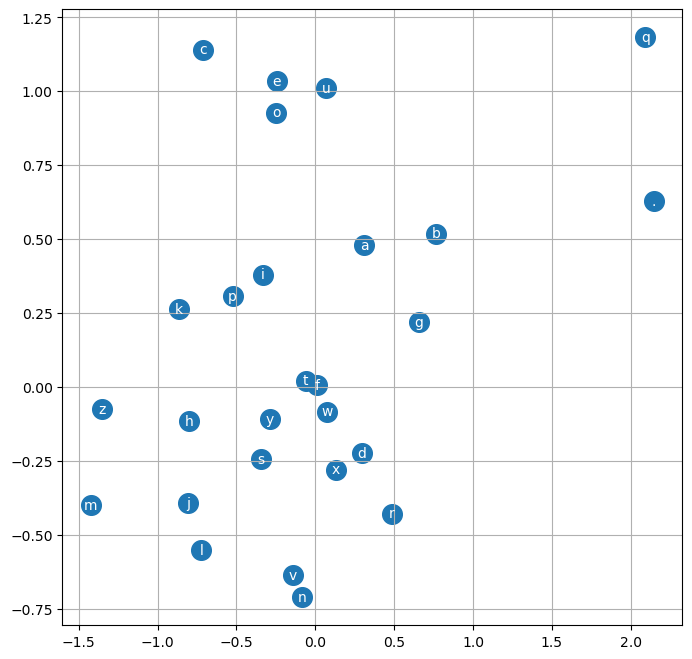

In [524]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
    
plt.grid("minor")

**How to improve this model?**
- Change the number of neurons in the hidden layer (`tanh`)
- Change the dimensionality of the embedding matrix `C`
- Change the number of characters in the context
- Change the hyperparameters (batch size, learning rate, epochs, etc)

**And... how do we generate characters with this method?**

In [525]:
g = torch.Generator().manual_seed(2147483647 + 10)

for i in range(20):
    output = []
    ix = 0
    
    context = [0] * block_size
    while True:
        
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (32, 100)
        logits = h @ W2 + b2 # (32, 27)
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        output.append(ix)
        
        if ix == 0:
            break
            
    print("".join(itos[i] for i in output))

carmah.
amelle.
khi.
mili.
tatyannah.
skellahnen.
deliah.
jareen.
ner.
kiah.
maiif.
kaleigh.
ham.
joce.
quintis.
lilea.
jamilio.
jero.
dearynn.
jace.


## 4. Multi-layer Perceptron Part 2

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

      0/ 200000: 27.8817
  10000/ 200000: 2.8263
  20000/ 200000: 2.5130
  30000/ 200000: 2.8010
  40000/ 200000: 2.0541
  50000/ 200000: 2.6152
  60000/ 200000: 2.3549
  70000/ 200000: 2.0835
  80000/ 200000: 2.2652
  90000/ 200000: 2.2635
 100000/ 200000: 2.0810
 110000/ 200000: 2.3367
 120000/ 200000: 1.9650
 130000/ 200000: 2.4398
 140000/ 200000: 2.1524
 150000/ 200000: 2.1201
 160000/ 200000: 2.0399
 170000/ 200000: 1.8172
 180000/ 200000: 2.0771
 190000/ 200000: 1.7632


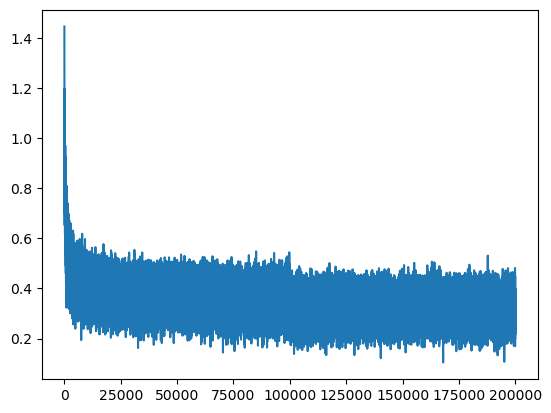

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1261181831359863
val 2.1693320274353027


### Step 1: Scrutinize the initialization (and the logits)

Our initial loss of `  0/ 200000: 27.8817` is too high, since at the beginnning we expect the probabilities for all characters to be drawn from a uniform distribution (all characters have equal probability to be the "next" character).

Therefore, this probability would be `1/27 = 0.037`, and the negative log probability is the loss we should expect:

In [10]:
-torch.tensor(1/27).log()

tensor(3.2958)

Ok, so what's going on? Let's replicate the issue with a universe of 4 characters instead of 27. Let's assume that the correct next character will be the third one in the list of 4 potential characters.
- First, this is what happens when all the logits are equal: The loss is appropriate (not too high nor too low)

In [11]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

- Now, this is what happens when the correct next character (third one) has a high score: the loss is low

In [12]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

- And this is what happens when the wrong characters have high scores: the loss is high

In [13]:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

- Now imagine we have a random tensor for logits (run this cell multiple times), we see that the loss varies within a given range (0-4), which reflects the fact that sometimes our random logits tensor will get the right response, and most of the times it won't.

In [14]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 0.6718,  0.5295, -0.8757,  1.1383]),
 tensor([0.2721, 0.2361, 0.0579, 0.4339]),
 tensor(2.8489))

- What happens if we scale the logits tensor with a high number? we get even higher losses most of the times, making it extremely hard to get to the right next character

In [15]:
logits = torch.randn(4) * 100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()

logits, probs, loss

(tensor([ -10.2387,   72.9310, -111.4177,   96.4750]),
 tensor([0.0000e+00, 5.9560e-11, 0.0000e+00, 1.0000e+00]),
 tensor(inf))

**CONCLUSION:** This means that what we're looking for is that our logits be as close as possible to zero (except maybe the score that represents the correct next character)!!!!!!!!!


**Cool! Now let's look at our training loop and stop it after the first iteration, to see what's going on**

In [16]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

11897
      0/ 200000: 27.8817


In [17]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

AHA!!!!! Our logits are quite large and definitely NOT close to zero. 

Let's look at our initialization. Logits depend on b2 and W2, so we can try to move them closer to zero.


- Make W2 smaller by multiplying it with a small constant
- Make b2 a zero-array at initialization

In [18]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

11897
      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


In [19]:
logits[0]

tensor([-1.0116,  2.1188, -0.9094, -1.7597, -0.6278,  2.2488, -1.7701, -1.4847,
        -0.5791,  2.8137, -1.0657, -1.6276,  2.5373,  1.6568,  3.6743,  1.5284,
        -0.2121, -4.8727,  1.9167,  1.3215,  0.7041, -0.7861,  0.7666, -2.0711,
        -4.5282,  2.6770,  0.0309], grad_fn=<SelectBackward0>)

Nice! Closer to what we expect - loss is low, and logits are closer to zero

In [20]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


11897
      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


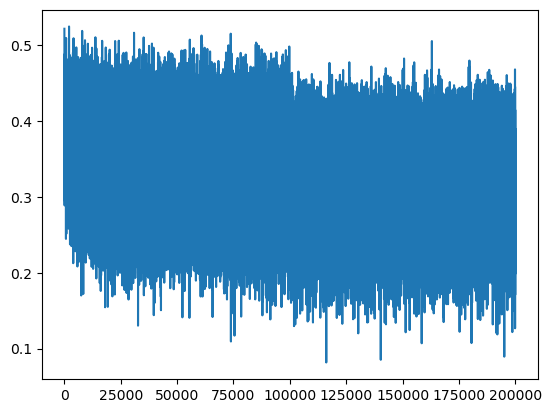

In [21]:
plt.plot(lossi)

Loss at initialization is what we expect, and the loss plot doesn't look like a hockey stick, ***which means we're spending more cycles actually optimizing the neural network, as opposed to just squashing down the weights, something that the neural networks was probably spending the first epochs doing.***

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695888996124268
val 2.131074905395508


And we can confirm that the losses have improved a bit.

### Step 2: Scrutinize the activations of the hidden state

In [23]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

11897
      0/ 200000: 3.3221


Recall that the `tanh` is a squashing function that compresses values in a range of `[-1, 1]`. Let's see what it looks like now:

In [24]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

In [25]:
h.shape

torch.Size([32, 200])

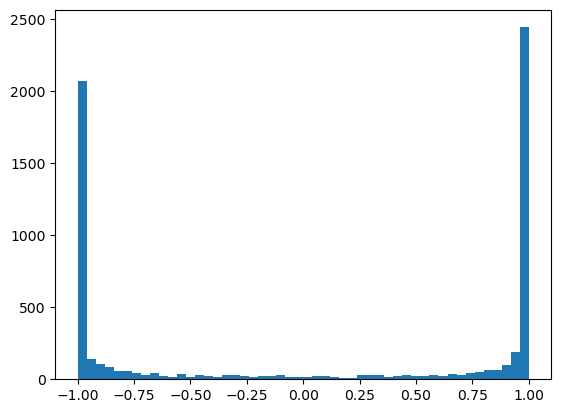

In [26]:
# The view -1 stretches it out to 1 large vector
# The semicolon suppresses the returned output from being printed
plt.hist(h.view(-1).tolist(), 50);

We can see that most values are very close to 1 and -1...

... This is because the distribution of the pre-activation values is very broad, so the `tanh` is basically squashing a lot of values to be between -1 and 1 and most of the numbers take very "extreme" values...

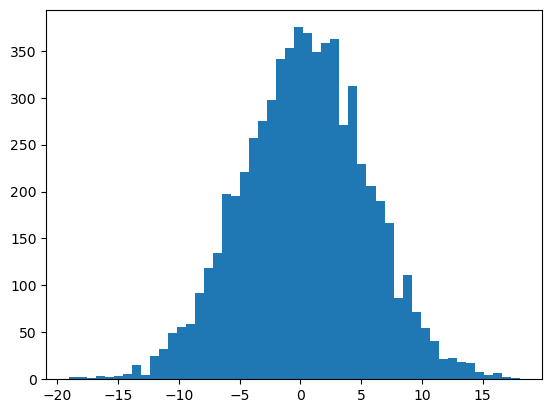

In [27]:
plt.hist(hpreact.view(-1).tolist(), 50);

**Why is this a problem?**

- If the activation values from the `tanh` function are too close to the flat parts of the curve (-1, 1), then during the backward pass the gradient will be really close to 0, which means that changing the weights at this point will cause almost no effect on the loss.
- This means that the gradient will "vanish".


But why?
- During the forward pass, we calculate `t` (the `tanh`), which will be between -1 and 1.
- During the backward pass, we multiply `(1 - t**2)` by the gradient of the `tanh`. So if `t` is -1 or 1, then no matter the value of the gradient of the `tanh`, the final value will be very close to zero. 
- If the output of the `tanh` neuron is close to 1 or -1, then changing the input by a little bit won't make much of a difference in the loss. Therefore, changes in weights and the biases won't affect the loss. 
- Which means that the weights in these neurons won't get updated much.
- The gradient that passes through `tanh` can only decrease.

Let's plot this - how many values out of `h` are very close to 1 or -1? Time for a boolean tensor!

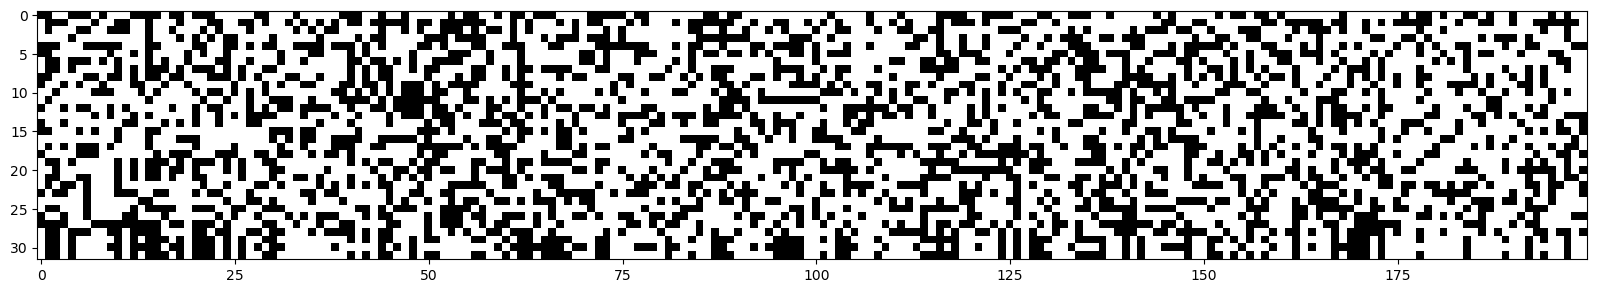

In [28]:
# The white color represents the values close to -1, 1. 
plt.figure(figsize=(20, 10))

# White if condition is true, black if condition is false. These are around 32 neurons!
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

If it was the case that there is an entire column that is white, then we'd have a "dead neuron", which means that no single example activated this neuron, which means that it wouldn't have learned.

**So what can we do?**

Similar to the case with the `W2` and `b2` tensors, we can squash the values of `W1` and `b1`, since they are the ones that influence the values that get fed to `tanh`, which get squashed along the extremes -1 and 1.

In [29]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

11897
      0/ 200000: 3.3135


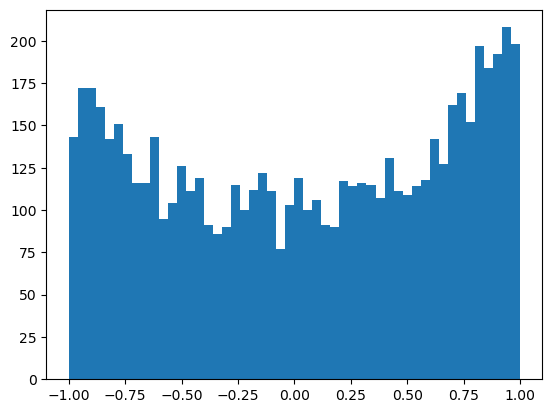

In [30]:
# The view -1 stretches it out to 1 large vector
# The semicolon suppresses the returned output from being printed
plt.hist(h.view(-1).tolist(), 50);

**We can see a massive difference, where most of the values are well distributed between -1 and 1!!!!!!!!!**

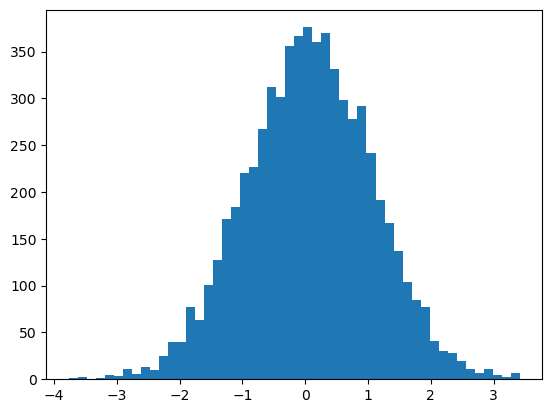

In [31]:
plt.hist(hpreact.view(-1).tolist(), 50);

And there's barely any white!!!

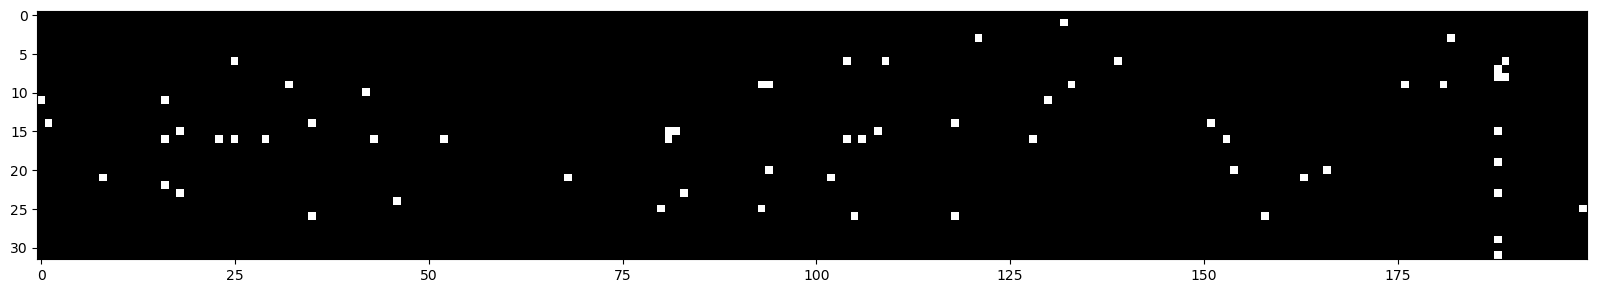

In [32]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Now, we can re-run the process and see what we get...

In [33]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


In [34]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.102678060531616


Splendid. That's an improvement.

#### NOTE

Notice how we are scaling the inputs by some arbitrary weight like 0.01 or 0.1. But how do we decide on this scaling factor at the beginning?

**PRELIMINARIES**

- Let's plot the mean and standard deviation of 2 random tensors `x` and `w` drawn from the gaussian distribution. We notice the their means will be close to 0 and the standard deviation close to 1. (Remember that the standard deviation is the measure of the spread of the distribution).
- When we multiply the tensors together into the tensor `y`, we see that the mean is the same as the individual tensors (because it's a symmetric operation), but the standard deviation has expanded to 3. Therefore, the gaussian is expanding. 
    - We don't want this! We want relatively similar activations across neurons.

tensor(-0.0006) tensor(0.9994)
tensor(0.0004) tensor(3.0532)


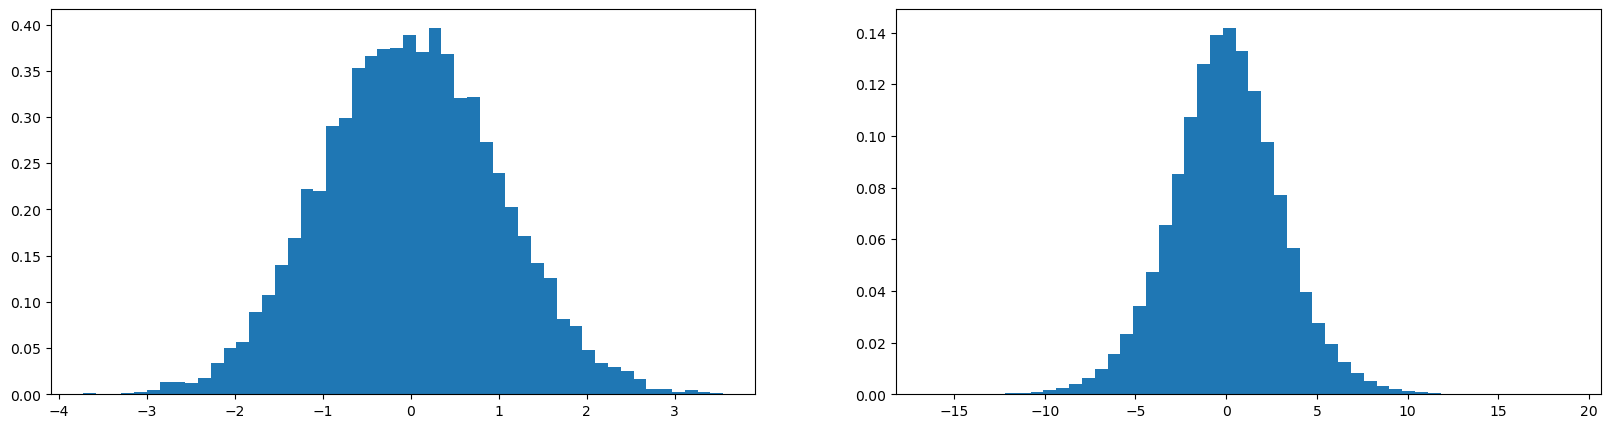

In [35]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

- So how can we get the standard deviation back to 1? ***by multiplying the tensors by some scalar!***. The larger the scalar, the larger the spread, and the smaller the scalar, the smaller the spread.
- The mathematical way of calculating such scalar would be the 1/(square root of the fan-in), where the fan-in is the number of elements in the tensor.

tensor(-0.0024) tensor(0.9973)
tensor(-0.0045) tensor(1.0013)


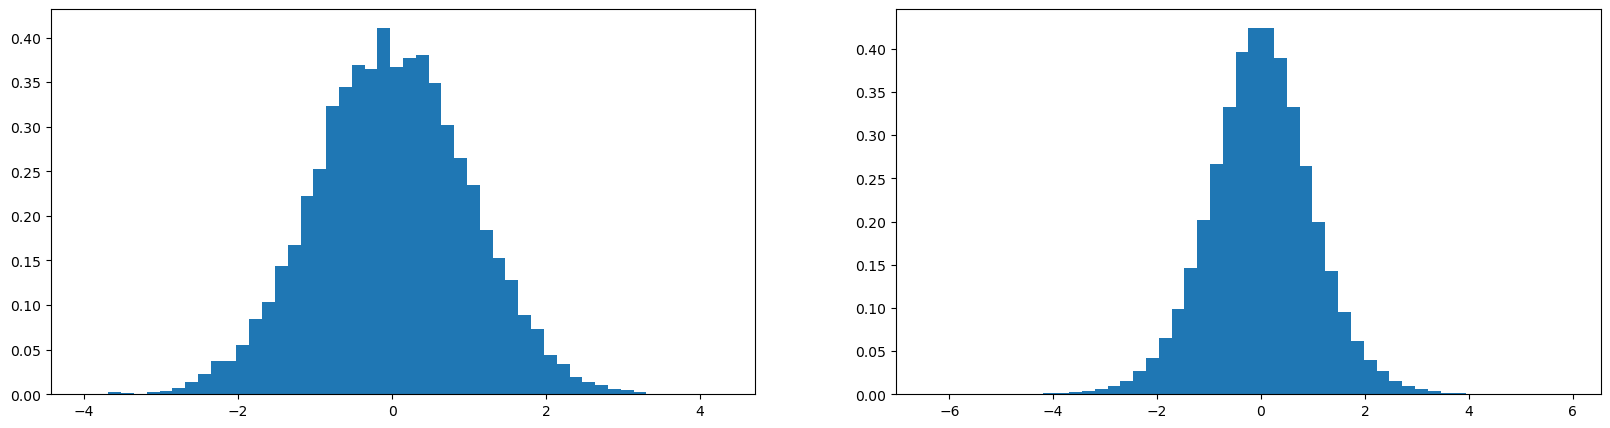

In [36]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5  # <- HERE! 1/sqrt(fan_in)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

But people have studied these initializations before! One of the most well-known ones is the Kaiming initialization: https://arxiv.org/pdf/1502.01852.pdf

- For ReLU, the scalar they find is `sqrt(2/fan_in)`, where the `2` comes from the extra squashing that occurs in the ReLU activation function.
- An interesting finding is that if you properly initialize the forward pass, the backward pass will also have "appropriate" behavior.
- This is available in PyTorch! https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
    - You can normalize the activations or the gradients! The default is activations.
    - You can also tweak the gain according to the non-linearity (ReLU vs. linear function). The gain for ReLU would be 2, and for a linear function it would be 1. In the case of tanh, the advised gain is 5/3. We need a gain because, similar to ReLU, the tanh function also squashes values within a range. 

#### NOTE 2:

BUT!!!!!!!!!!!! We don't need to be so cautious about initializations anymore, due to innovations like:
- Residual connections
- Normalization layers
- Better optimizers, like Adam

In practice, ***just normalize the weights by the square root of the fan-in, or use the init Kaiming normal in PyTorch**.

In [37]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [38]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


### Step 3: Batch normalization

Original paper: https://arxiv.org/pdf/1502.03167.pdf

Main idea: Normalize the weights in the activation function by... normalizating the values. In other words, subtract the pre-activation tensor's mean from the pre-activation tensor, and divide it by the standard deviation of the same tensor.

However! We want the activations to be more gaussian, but only at initialization. We don't want them to **always** be gaussian, because we want backpropagation to be able to modify the values every so often during training, we'd like the distribution to move around. In other words, we don't want to **only** normalize on every iteration!

Enter the concept of scaling and shifting.

- Take the normalized inputs, scale them by some gain, and offsett them by some bias

In [39]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain*(hpreact - hpreact.mean(dim=0, keepdim=True))/hpreact.std(dim=0, keepdim=True) + bnbias # This normalizes the activations
    
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

12297
      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [40]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    hpreact = bngain*(hpreact - hpreact.mean(dim=0, keepdim=True))/hpreact.std(dim=0, keepdim=True) + bnbias # This normalizes the activations
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


We shouldn't see too much of an improvement because:
- This is a very small, simple network
- We're already scaling W1 at the beginning to make the pre-activations to have a roughly gaussian shape, which makes batch normalization less relevant

In practice, it is common to add a batch normalization layer after linear and convolution layers, to **stabilize the training** by controlling the activations and their distributions.

#### BUT!

Stability comes at a cost. ***We're coupling the inputs because we're using normalization!*** - the hidden state activations for a given input example are also a function of the other examples that come in the batch (which are sampled randomly), which means that these activations will change a bit according to all the examples in the batch, because the mean and standard deviation will be affected. 

*Is this... bad?*. Not necessarily, because this works as a **"regularization"** mechanism that prevents overfitting by adding some noise to the processing of individual examples!

Still, people have been trying to remove it to avoid the coupling of inputs that it leads to. Some alternatives are Layer Normalization or Group Normalization.


#### ANOTHER BUT!

If we want to deploy this neural net and get a prediction for a single example, how do we do this with batch normalization given that now it expects a batch instead of a single example?

In the paper, the authors propose to calculate the mean/std statistics from the training set at the end of training and store this value. 

In [41]:
# Calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [42]:
# And instead of using the dynamic mean/std calculation, we'll use what we previously calculated.
@torch.no_grad() 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    # hpreact = bngain*(hpreact - hpreact.mean(dim=0, keepdim=True))/hpreact.std(dim=0, keepdim=True) + bnbias # This normalizes the activations
    hpreact = bngain*(hpreact - bnmean)/bnstd + bnbias # This normalizes the activations
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066890239715576
val 2.1049015522003174


But no one wants to do this after training - too much time and effort. So the authors propose to calculate a "running" mean and std during training, so that we only have a single pass through the dataset.

In [43]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Batch normalization terms initialized
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# NOTE: we initialize these as zeros and ones because we were using a unit gaussian to generate the weights at the beginning
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # Mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # Forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    # Batch normalization
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani)/bnstdi + bnbias # This normalizes the activations
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

12297
      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


Let's check that the `bnmean` and `bnstd` from the explicit estimation are similar to the running mean and std that we calculated during training

In [44]:
# Calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [45]:
bnmean - bnmean_running

tensor([[ 3.9163e-02,  1.9044e-04, -1.3526e-02, -1.9299e-02, -1.3297e-03,
         -2.2174e-03,  8.3019e-03,  2.4975e-02,  2.1044e-02,  1.2813e-02,
         -2.1025e-03,  1.2470e-02,  9.4693e-03, -1.3099e-02, -1.7027e-02,
         -1.5407e-02, -2.4322e-03,  2.9587e-02,  3.5897e-02, -3.3820e-03,
          6.7838e-03, -3.1887e-02, -5.3245e-03,  3.0277e-03, -1.2617e-02,
         -1.5393e-02, -1.5411e-02,  6.5140e-03, -6.9256e-03,  2.5504e-03,
          9.4721e-03,  6.8712e-04, -6.5569e-03,  1.7523e-02,  1.0551e-02,
          9.0867e-03,  3.1711e-03,  1.0262e-02, -1.4565e-02, -2.1940e-02,
          8.5105e-03,  2.7319e-02, -1.0624e-02,  1.5141e-02,  8.3101e-04,
         -4.2760e-03,  1.8041e-03,  2.5296e-02, -2.5606e-03,  2.4847e-02,
          1.7852e-02,  1.6065e-02,  1.9173e-02, -3.6942e-03,  1.8144e-02,
          4.6086e-03, -1.0223e-02, -1.4621e-02, -2.3566e-02, -1.7233e-02,
          1.4803e-02,  1.5833e-02,  1.2961e-02,  1.2029e-02, -1.9505e-03,
          2.1013e-02, -8.8644e-04,  1.

In [46]:
bnstd - bnstd_running

tensor([[0.0239, 0.0366, 0.0164, 0.0345, 0.0345, 0.0307, 0.0145, 0.0347, 0.0269,
         0.0221, 0.0293, 0.0318, 0.0327, 0.0212, 0.0335, 0.0240, 0.0232, 0.0184,
         0.0191, 0.0155, 0.0329, 0.0259, 0.0200, 0.0276, 0.0202, 0.0218, 0.0282,
         0.0300, 0.0154, 0.0302, 0.0226, 0.0059, 0.0045, 0.0183, 0.0078, 0.0249,
         0.0125, 0.0315, 0.0296, 0.0171, 0.0231, 0.0309, 0.0360, 0.0342, 0.0230,
         0.0139, 0.0258, 0.0571, 0.0229, 0.0146, 0.0334, 0.0295, 0.0245, 0.0207,
         0.0212, 0.0238, 0.0225, 0.0154, 0.0145, 0.0227, 0.0196, 0.0111, 0.0112,
         0.0098, 0.0244, 0.0224, 0.0229, 0.0318, 0.0281, 0.0233, 0.0316, 0.0139,
         0.0131, 0.0204, 0.0216, 0.0146, 0.0142, 0.0312, 0.0200, 0.0197, 0.0201,
         0.0247, 0.0346, 0.0307, 0.0188, 0.0378, 0.0269, 0.0231, 0.0067, 0.0088,
         0.0266, 0.0257, 0.0065, 0.0236, 0.0066, 0.0307, 0.0264, 0.0199, 0.0295,
         0.0291, 0.0021, 0.0271, 0.0393, 0.0238, 0.0246, 0.0292, 0.0178, 0.0416,
         0.0168, 0.0320, 0.0

Pretty close! 

In [47]:
# And instead of using the dynamic mean/std calculation, we'll use what we previously calculated.
@torch.no_grad() 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    # hpreact = bngain*(hpreact - hpreact.mean(dim=0, keepdim=True))/hpreact.std(dim=0, keepdim=True) + bnbias # This normalizes the activations
    hpreact = bngain*(hpreact - bnmean_running)/bnstd_running + bnbias # This normalizes the activations
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066591501235962
val 2.1050572395324707


Barely no change to the loss! 

**Recall the losses we had so far:**

- At the beginning:
    - train 2.1261181831359863
    - val 2.1693320274353027
- After fixing the initial loss
    - train 2.0695888996124268
    - val 2.131074905395508
- After fixing the tanh activations
    - train 2.0355966091156006
    - val 2.102678060531616
- After using the Kaiming initialization (expecting a similar result as what we got after fixing the tanh activations)
    - train 2.0376641750335693
    - val 2.106989622116089
- After using batch normalization (both with running mean and single calculation mean/std)
    - train 2.0668270587921143
    - val 2.104844808578491



**NICE!** These may look like small improvements but the problems can stack up, so it is good that we tackled them at the beginning.

**ONE LAST THING**

We are being a bit "wasteful" with our computations. 

We're not actually using the bias added to `hpreact` because we're calculating the mean and subtracting it from `hpreact` later, which gets rid of the bias we added earlier. This means that whenever we calculate the gradient for the bias term, it will be zero. 


*Therefore*, whenever we have a batch normalization layer, we don't use a bias term for the activations - and instead we use a bias term in the batch normalization layer instead. 


In [48]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Batch normalization terms initialized
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# NOTE: we initialize these as zeros and ones because we were using a unit gaussian to generate the weights at the beginning
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # Mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # Forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    
    # Batch normalization
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani)/bnstdi + bnbias # This normalizes the activations
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

12297


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

#### Summary of batch normalization
- We use batch normalization to control the statistics of the activations in the neural net
- It is common to use it after layers that have multiplications, like linear/convolution layers
- Internally, it has parameters for the gain and the bias that are trained using back propagation. It also has buffers like the mean and the standard deviation that are updated using a "running" style calculation.
- What is this layer doing?
    - Calculating the mean and std of the activations fed to the batch norm layer over that batch
    - Center that batch to be unit gaussian
    - Offset and scale it by the learned bias and gain
    - Meanwhile, keep track of the mean/std of the inputs, so that they can be used for inference later.

### 4.1 Pytorchifying code 

In [92]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        # Momentum is used for keeping track of the running mean/variance
        self.eps = eps
        self.momentum = momentum
        
        # This parameter is set to true because many modules have different behavior depending on whether they are on training mode or on inference mode
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim) # gain
        self.beta = torch.zeros(dim) # bias
        
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) # REMEMBER: Variance is the standard deviation squared
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalization to unit variance
        
        # NOTE: This is not internal to PyTorch, we just added it to keep track of statistics/logging
        self.out = self.gamma * xhat + self.beta
        
        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

# 6 layers
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [93]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # Mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # Forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    # hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    for layer in layers:
        x = layer(x)
    
#     # Batch normalization
#     bnmeani = hpreact.mean(dim=0, keepdim=True)
#     bnstdi = hpreact.std(dim=0, keepdim=True)
#     hpreact = bngain*(hpreact - bnmeani)/bnstdi + bnbias # This normalizes the activations
    
#     with torch.no_grad():
#         bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
#         bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
#     # Non-linearity
#     h = torch.tanh(hpreact) # hidden layer
#     logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(x, Yb) # loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: Would take out retain_graph
    
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break

      0/ 200000: 3.2870


#### Actual visualizations

How many values in the activation tensors take on any of the values in the x axis of the plot?

Layer 2 (      Tanh): mean -0.00, std 0.63, saturated 2.78
Layer 5 (      Tanh): mean +0.00, std 0.64, saturated 2.56
Layer 8 (      Tanh): mean -0.00, std 0.65, saturated 2.25
Layer 11 (      Tanh): mean +0.00, std 0.65, saturated 1.69
Layer 14 (      Tanh): mean +0.00, std 0.65, saturated 1.88


Text(0.5, 1.0, 'Activation distribution')

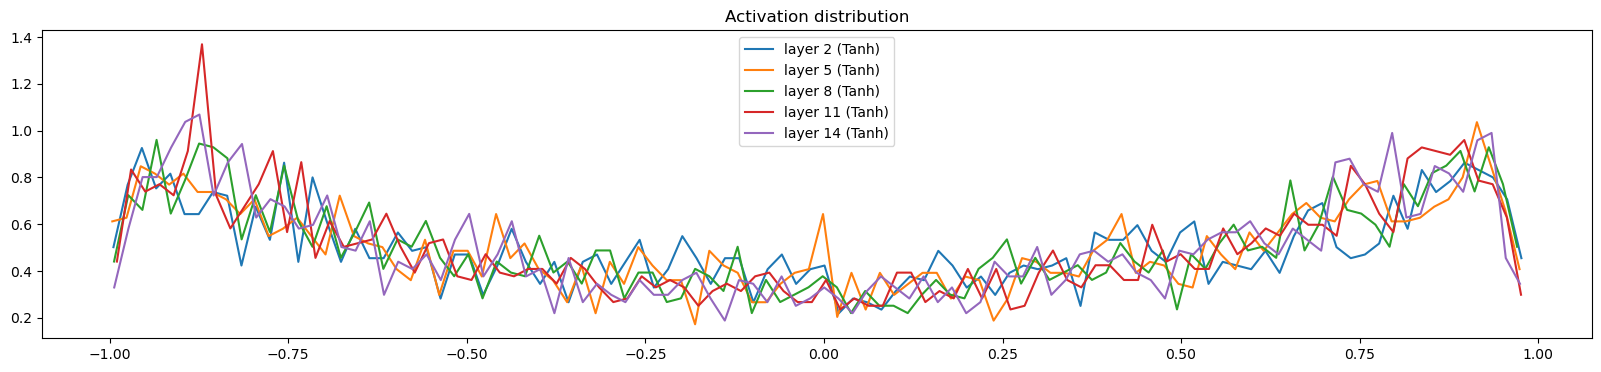

In [94]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i} ({layer.__class__.__name__:>10}): mean {(t.mean()):+.2f}, std {t.std():.2f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Activation distribution")

Now let's plot the gradients!

Layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
Layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
Layer 8 (      Tanh): mean -0.000000, std 2.045742e-03
Layer 11 (      Tanh): mean +0.000000, std 1.983134e-03
Layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'Activation distribution')

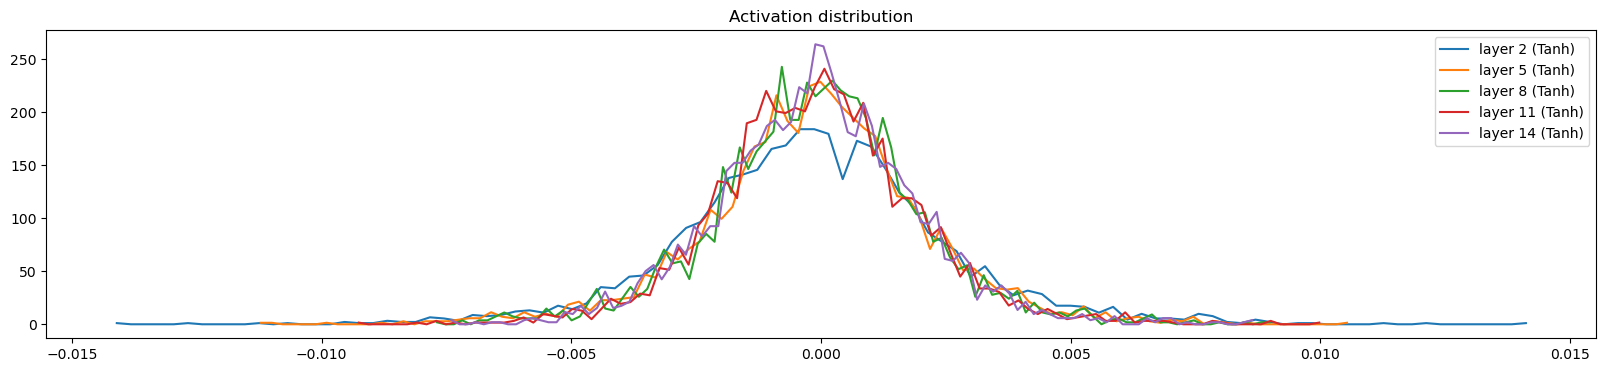

In [95]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {i} ({layer.__class__.__name__:>10}): mean {(t.mean()):+f}, std {t.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Activation distribution")

Ok, what about the ***weights*** themselves?

- We're interested in the gradient to data ratio. We wanna know: What is the scale of the gradient, in comparison to the scale of the actual values? This is because we're gonna take a step update that is the learning rate * the gradient, onto the data.
    - If the numbers in the gradient are too large, you'd have a hard time making that step update.

weight   (27, 10) | mean +0.000000 | std 8.020539e-03 | grad:data ratio 8.012635e-03
weight  (30, 100) | mean +0.000246 | std 9.241082e-03 | grad:data ratio 4.881094e-02
weight (100, 100) | mean +0.000113 | std 7.132884e-03 | grad:data ratio 6.964625e-02
weight (100, 100) | mean -0.000086 | std 6.234306e-03 | grad:data ratio 6.073742e-02
weight (100, 100) | mean +0.000052 | std 5.742189e-03 | grad:data ratio 5.631484e-02
weight (100, 100) | mean +0.000032 | std 5.672207e-03 | grad:data ratio 5.570126e-02
weight  (100, 27) | mean -0.000082 | std 1.209416e-02 | grad:data ratio 1.160106e-01


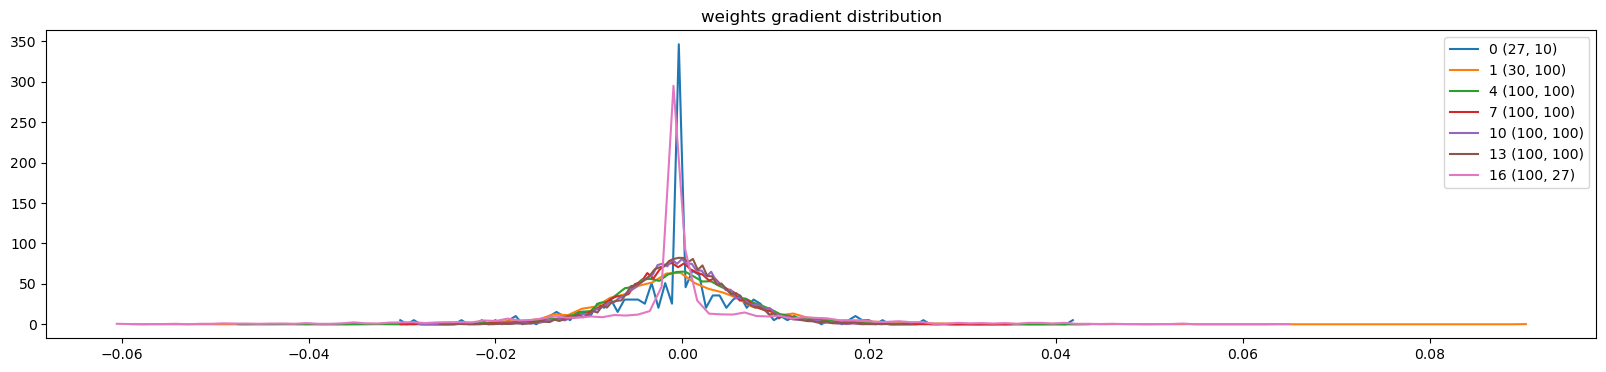

In [96]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

BUT!!!!!!!! What matters is the update to data ratio.

So also measure how much are we updating the weights. How great are the updates to the values in these tensors????

We'll visualize the exponents of the ratio through our `ud` tensor.

**NOTE:** Changing the gain in batch norm won't affect the behavior of the foward/backward pass, but it will affect the behavior of this ratio (how great of an update we give to the weights).


For these update-to-data ratios, ~1e-3 is a good heuristic for where you want it to be. If it is way too high, then the learning rate may be too big, and the converse is true as well.

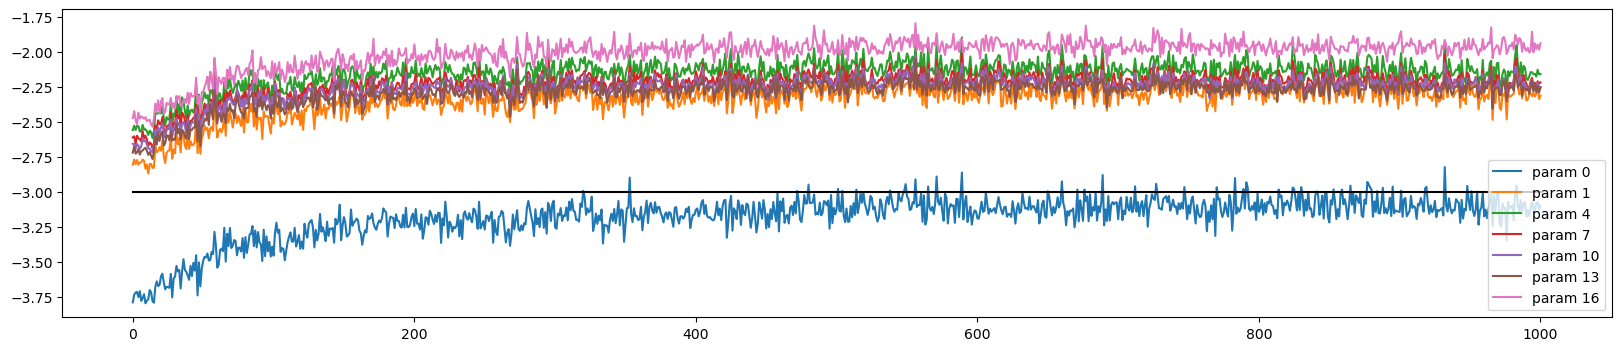

In [97]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

**GOOD QUESTION: Why do we need a Tanh in the first place?**

If we were to only use a stack of linear layers, that gets collapsed into a single linear layer. 

The tanh just adds non-linearity, in order to be more expressive in the types of functions it can learn.

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
        
    print(''.join(itos[i] for i in out))

Overall great lecture, I did lack a bit of intuition for understanding the visualizations - but will get into that more next time! 

## 5. BECOMING A BACKPROP NINJA

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [18]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [19]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [20]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [21]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [22]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.4960, grad_fn=<NegBackward0>)

In [29]:
# emb = C[Xb] # embed the characters into vectors
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [ ]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

### Exercise 1: Backpropagate through each operation

In [31]:
# TODO: MOVE EACH OF THESE TO THEIR OWN CELL
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# For dlogprobs, we're calculating the derivative of logprobs w.r.t loss, and their relationship is:
# loss = -logprobs[range(n), Yb].mean()
# So the operations are: mean() and negative (*-1)
# Thus the derivative dloss/da would be -1/n, where n is the size of the batch
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

# For dprobs, it will be the local derivative of applying the log() * the derivative of the loss w.r.t to this output (dlogprobs)
# Original statement: logprobs = probs.log()
# Recall that d/dx log(x) = 1/x
# Intuition: If your probs is very close to 1, then the network is predicting the next char correctly.
#            Then dlogprobs just gets passed through. 
#            But if the character is being predicted incorrectly, then the value of dlogprobs will be boosted
dprobs = (1.0 / probs) * dlogprobs

# For dcounts and dcounts_sum_inv. Original statement: probs = counts * counts_sum_inv
# -> Toy example: c = a * b, but with tensors:
# - a[3x3] * b[3,1] 
# - Where a is counts and b is counts_sum_inv
# - Given the shapes of the tensors, what pytorch is doing is actually 2 operations: 
# --> First, replicate b to match the number of columns of a
# --> Then, apply the multiplication
# When thinking about the derivative for the second step, we assume that we have already replicated counts_sum_inv
# and we just take the local derivative of `counts_sum_inv` with respect to `probs` and we get just `counts` because it is multiplication.
# and we multiply it by the derivative of dprobs (because of the chain rule).
# For the next step (replicating the columns of b), we know that when a node is used multiple times, the gradient for all of its uses is summed horizontally accross all the rows
# and we want to retain the dimensions.
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

# Similar logic based off of our c = a * b example. The a here is `counts`
# However, notice that `counts_sum_inv` is written in terms of `counts_sum` and then `counts` (so `counts` is used twice)
dcounts = counts_sum_inv * dprobs
# So! Let's calculate `dcounts_sum` first. Notice that `counts_sum_inv` is equal to or 1/counts_sum, and the derivative of that would be -1/(counts_sum^2) or -(counts_sum^-2)
dcounts_sum = (-counts_sum**-2)*dcounts_sum_inv
# Now let's calculate the second effect of `counts` in the loss function (as part of `counts_sum_inv`) and add it to the original `dcounts`
# What we're doing here is just multiplying b by a matrix of ones that is the shape of a.
# The reasons is because all the columns of a are being added and then multiplied to b, which means that the local derivative of all the elements of a is going to be 1, and its effect on b will be 1 depending on which row of a gets multiplied by which row of b (for example b_1 only depends on the row of a_1 = [a_11, a_12, a_13]
# We'll let torch do the broadcasting here.
dcounts += torch.ones_like(counts) * dcounts_sum

# Phew! Ok, time for `dnorm_logits`. Original statement: `counts = norm_logits.exp()`
# The infamous derivative of e^x is e^x. Moreover, we have already calculated this - it's just `counts`
dnorm_logits = counts * dcounts

# Now `dlogit_maxes` and `dlogits`. Original statement: `norm_logits = logits - logit_maxes`
# A good way to think about this is our toy example: c = a - b
# Therefore the derivatives with respect to c will be 1 and -1, respectively. So time for some cloning!
dlogits = dnorm_logits.clone()
# BUT recall that there's a difference in shape, and since we'll be broadcasting logits_max by multiplying its columns, we gotta add a sum() here
dlogit_maxes = -dnorm_logits.clone().sum(1, keepdim=True)
# Fun post-derivative fact: this should technically be super close to zero, as the impact of this particular operation in the final loss function is negligible, since we're doing this for numerical stability! 
# ANOTHER BUT! we also use `logits` to define `logit_maxes`. Since this operation is a max(), it's the equivalent to multiplying `dlogit_maxes` by 1 in every index belonging to the max element in `logits`, and zero in the other positions. So... time for one hot encoding!
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

# Hehe that was a cool hack. We're almost there. Now it's time for `dh`, `dW2` and `db2`.
# Original statement: `logits = h @ W2 + b2`. A linear layer! Let's decompose that:
# d = a @ b + c
# This is a combo of:
# The derivative of the loss w.r.t a. dL/da = dL/dd * b^T (where dd is `dlogits`)
# The derivative of the loss w.r.t b. dL/db = a^T @ dL/dd 
# The derivative of the loss w.r.t c. dL/dc = dL/dd .sum(0)
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits
db2 = dlogits.sum(0, keepdim=True)

# Time for the hidden layer, `dhpreact`. Original statement: h = torch.tanh(hpreact)
# a = tanh (z). da/dz = 1 - a^2
dhpreact = (1 - h**2) * dh

# Now the batch norm parameters! Original statement: hpreact = bngain * bnraw + bnbias
# and to our toy example, d = a * b + c
# Remember: As intuitive as our toy example is, we need to add .sum(i) whenever we find that broadcasting is happenning and therefore we gotta match the resulting shapes of the derivative.
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

# NEXT UP: DBNVAR_INV! Or rather dbndiff. LMAO these variable names...
# Original statement: bnraw = bndiff * bnvar_inv
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

# NOTICE: Every time you have a sum() in the forward pass, that indicates some sort of replication/broadcasting in the backward pass.
# Conversely, when we have replication in the forward pass, it turns into a sum() in the backward pass
# Good process for calculating the gradients:
# 1. Understand the shapes, what's going on, how would they change
# 2. Try out a toy example with few dimensions
# For example, picture this -> bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# A toy example would be a 2x2 matrix:
# a11 a12
# a21 a22
# -----------
# Which ends up being a 2 dimensional vector
# b1 b2, where
# b1 = 1/(n-1) * (a11 + a21)
# b2 = 1/(n-1) * (a12 + a22)
dbndiff2 = (1/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff)*dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff.sum(0)) # Don't forget about the sum over rows lmao to remove this dimension
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# NOW LET'S BACKPROPAGATE THROUGH THE LINEAR LAYER WOHOOOO
# Original statement: hprebn = embcat @ W1 + b1
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

### Exercise 2: Backpropagate through cross-entropy in one go

In [32]:
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.496013879776001 diff: -2.384185791015625e-07


In [34]:
# backward pass

# Derived using rules for dx/d log(x) = 1/x and the product rule, and remember that there are 2 cases -> when the label is correct (i = y) and when the label isn't correct (i != y)
# Simplifying cross-entropy:
#    loss = -log(P_y)
#    P_i = e^(l_i)/\sum_{j} e^{l_j}
#    loss = -log(e^(l_y)/\sum_{j} e^{l_j}
# We land with:
# - When i != y: The derivative is P_i
# - When i == y: The derivative is P_i - 1
# Where p_i is the softmax of the logits over the y-th dimension 
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1 # This is applying the case where the labels are correct
dlogits /= n # This is averaging it out, since we're using batches

cmp("logits", dlogits, logits) # we won't get an exact match maxdiff will be ~5e-09

logits          | exact: False | approximate: True  | maxdiff: 5.3551048040390015e-09


**Let's get an intuition on what the hell dlogits is**

In [45]:
# We have a batch of 32 examples of 27 characters (logits.shape = [32, 27])
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [38]:
# Taking the first probability row
F.softmax(logits, 1)[0]

tensor([0.0386, 0.0180, 0.0240, 0.0198, 0.0444, 0.0555, 0.0959, 0.0215, 0.0399,
        0.0380, 0.0306, 0.0297, 0.0426, 0.0463, 0.0588, 0.0623, 0.0575, 0.0206,
        0.0254, 0.0267, 0.0431, 0.0121, 0.0214, 0.0266, 0.0325, 0.0257, 0.0425],
       grad_fn=<SelectBackward0>)

In [39]:
# `dlogits` of the first row. It's exactly equal to the probability EXCEPT with a position that has a -1
dlogits[0] * n

tensor([ 0.0386,  0.0180,  0.0240,  0.0198,  0.0444,  0.0555,  0.0959,  0.0215,
         0.0399,  0.0380,  0.0306,  0.0297,  0.0426,  0.0463,  0.0588,  0.0623,
         0.0575,  0.0206, -0.9746,  0.0267,  0.0431,  0.0121,  0.0214,  0.0266,
         0.0325,  0.0257,  0.0425], grad_fn=<MulBackward0>)

In [42]:
# This sums to zero (basically)
dlogits[0].sum()

tensor(-2.3283e-09, grad_fn=<SumBackward0>)

Think of each gradient in each cell as a force, ***pulling down on the probabilities of the incorrect characters and pulling up on the probabilities of the correct characters***, and the amount of force is equalized since the sum of all the gradients equals zero. 

Then the neural network is just trying to tug (pushing and pulling) in the direction of the correct answers. The amount of force is proportional to the probabilities that came out in the forward pass. Suppose that all the probabilities came out correct on the first pass (so all of them equal zero except for a one in the correct position), then `dlogits` would be a row of zeros for that example, since there wouldn't be a push and pull. This means that the amount of incorrectness of your prediction will be exactly the amount that you'll get a pull (or a push) in that specific dimension. The amount to which you misspredict is proportional to the strength of the pull. 

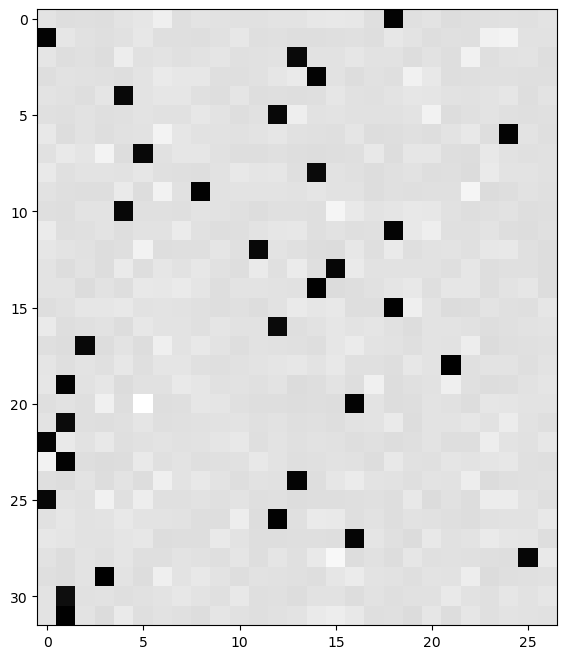

In [43]:
# Here, we can see that we have a batch of 32 examples of 27 characters (logits.shape = [32, 27])
# `dlogits` is the probabilities matrix in the forward pass
# The black squares represent the correct indices in that matrix, where we subtracted 1 (for the case where i == y) in the derivative
# In other words, the black squares represent the "pushing" of the correct answer!
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap="gray")

### Exercise 3: Backpropagate through batchnorm in one go

In [44]:
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [46]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)


# TODO: Take a screenshot of Karpathy's notes and just add that as an attachment lol I'm not rewriting all of that in latex.
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


### Exercise 4: Putting it all together

In [51]:
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
# NOTE: DAMN, this definitely feels empowering
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #     break

12297
      0/ 200000: 3.6492
  10000/ 200000: 2.4559
  20000/ 200000: 2.3771
  30000/ 200000: 2.1087
  40000/ 200000: 2.0224
  50000/ 200000: 2.5101
  60000/ 200000: 2.3600
  70000/ 200000: 2.0921
  80000/ 200000: 1.9810
  90000/ 200000: 2.0441
 100000/ 200000: 2.3831
 110000/ 200000: 2.0453
 120000/ 200000: 2.1862
 130000/ 200000: 2.3883
 140000/ 200000: 2.3041
 150000/ 200000: 2.4640
 160000/ 200000: 2.0640
 170000/ 200000: 1.9879
 180000/ 200000: 2.2862
 190000/ 200000: 1.8927


In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

In [52]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [53]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0703177452087402
val 2.11358642578125


In [54]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carlah.
ambrilli.
kimrix.
taty.
skansh.
emmahnin.
delynn.
jareei.
ner.
kiah.
maiivon.
leigh.
ham.
jord.
quinton.
lilea.
jadiquo.
jero.
dearyxia.
kaellius.


## 6. Makemore Part 5: WaveNet

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [108]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [109]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


**Pytorchifying the code more:**
- Adding the `Sequential`, `Embedding`, `Flatten` classes.

In [152]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:
    
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []


# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
    """Flattens some N consecutive elements and puts them in the last dimension"""
  
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape # batch size, block/context size, embedding dimension
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1: # In case we have a spurious (fake) dimension in the 1st dimension place, we take it out
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [153]:
torch.manual_seed(42); # seed rng for reproducibility

In [169]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP


og_model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(), Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size)
])

hierarchical_model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size)
])

# Set up which model we want
model = hierarchical_model

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


In [170]:
# Scratchspace 
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  1, 12,  1,  9, 14,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 14],
        [ 0,  0,  0,  0,  0,  0,  0, 19],
        [ 0,  0,  0,  0,  0,  1,  2,  4]])

In [171]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [163]:
model.layers[0].out.shape # Embedding layer

torch.Size([4, 8, 10])

In [116]:
model.layers[1].out.shape # Flatten layer

torch.Size([4, 80])

In [117]:
model.layers[2].out.shape # Linear layer

torch.Size([4, 200])

In [122]:
# Recall that we have a batch of 4 examples, each of which has a 10-dimensional embedding for each of its 8 characters, which is flattened in a 4x80 matrix. 
# This is the current way of doing the linear layer:
print((torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)

# QUESTION: IS THIS TO TAKE INTO ACCOUNT BIGRAMS IN THE NEW HIERARCHICAL ARCHITECTURE? I THINK SO
# But actually, we want to make this more efficient by parallelizing the matrix multiplication step, by creating smaller batches -> adding a "batch dimension"
# In particular, we're converting each example into 4 groups of 2 characters instead of a single row of 8 characters, and applying this to the first matrix
# going from 4x80 into a 4x4x20 matrix 
# [1 2 3 4 5 6 7 8]
# [[1 2] [3 4] [5 6] [7 8]]
print((torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape)

torch.Size([4, 200])
torch.Size([4, 4, 200])


In [145]:
# Therefore, our goal is to turn our (4, 8, 10)-shaped matrix into a (4, 4, 20)-shaped matrix where consecutive 10-d vectors get concatenated
e = torch.randn(4, 8, 10)

# Current Flatten operation:
print(e.view(e.shape[0], -1).shape)

# A potential option:
# Let's use some Python indexing tricks to get the odd/even elements in our matrix. 
# Even characters: e[:, ::2, :]. Shape is (4, 4, 10)
# Odd characters: e[:, 1::2, :]. Shape is (4, 4, 10)
# Then we want to concatenate them along the second dimension to get a (4, 4, 20) matrix
print(f"{e[:, ::2, :].shape=}")
explicit_cat = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
print(f"{explicit_cat.shape}")

# OR! We could just use .view LMAO
(e.view(4, 4, 20) == explicit_cat).all()

torch.Size([4, 80])
e[:, ::2, :].shape=torch.Size([4, 4, 10])
torch.Size([4, 4, 20])


tensor(True)

In [173]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # break

      0/ 200000: 3.2854
  10000/ 200000: 2.0588
  20000/ 200000: 1.8410
  30000/ 200000: 2.0795
  40000/ 200000: 2.3229
  50000/ 200000: 2.2484
  60000/ 200000: 2.1177
  70000/ 200000: 2.0232
  80000/ 200000: 1.6062
  90000/ 200000: 2.3045
 100000/ 200000: 2.0915
 110000/ 200000: 1.7432
 120000/ 200000: 2.1273
 130000/ 200000: 1.6245
 140000/ 200000: 2.3767
 150000/ 200000: 1.6331
 160000/ 200000: 2.0308
 170000/ 200000: 2.1759
 180000/ 200000: 1.8018
 190000/ 200000: 1.9507


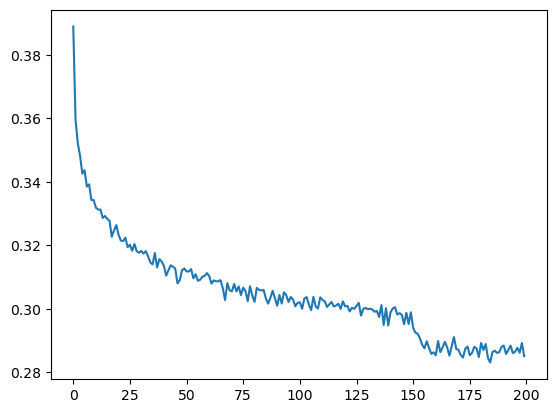

In [174]:
# Fix plot by averaging out the loss per every 1000 steps.
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [175]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [176]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9125672578811646
val 2.021854877471924


#### Performance log
- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8, 22K params: train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029

In [177]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

emeray.
chadeter.
hurham.
naiyah.
que.
mossim.
jessie.
ikyah.
chavion.
moran.
haitian.
keiyah.
johnna.
cescon.
ramael.
junonec.
tannemi.
josae.
haaed.
jaycen.
